In [1]:
import numpy as np
from scipy import integrate, constants, misc, interpolate
import pylab as pl
import matplotlib.pyplot as plt

from numpy import zeros_like, mgrid, zeros
from scipy.special import erf, jv, jn, jn_zeros, jvp

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from scipy.integrate import quad
from scipy.constants import mu_0
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec



%matplotlib inline

pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [2]:
#Initializing parameters

N       = 500          #No. of terms used in expansion
alpha   = 0            #Order of bessel function
b       = 20           #Range of function

nr      = 500         #No. of terms used for plotting
epsilon = 0.00001      #A small value at which plot starts


r       = np.linspace(epsilon, b, nr)
x       = np.linspace(epsilon, 25, nr)

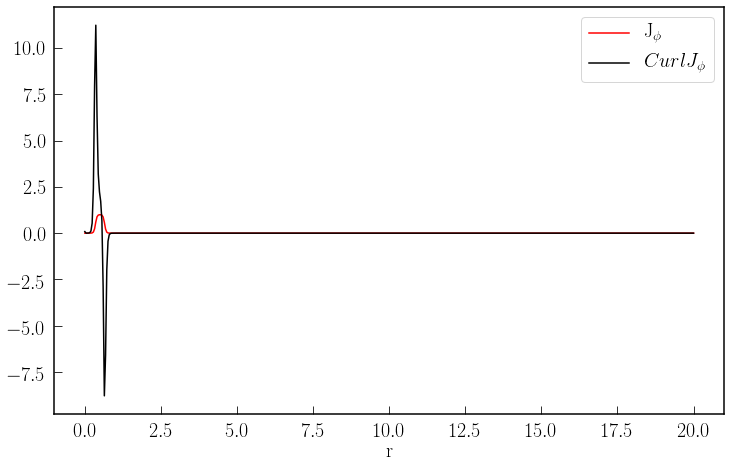

In [3]:
#This function is used to model the current density as a step function
def j_phi(r):
    regulator = 1/20.
    f = 0.5 * (np.tanh((1.0/regulator)*(r-0.35)) - np.tanh((1.0/regulator) * (r-0.65)))

    #f = (r*(-0.5*(np.tanh((r - 0.35)/regulator)**2 - 1)/regulator + 0.5*(np.tanh((r - 0.65)/regulator)**2 - 1)/regulator) + \
    #     0.5*np.tanh((r - 0.35)/regulator) - 0.5*np.tanh((r - 0.65)/regulator))/r

    return f

#This function is the curl of the function used to model current density above
def curl_j_phi(r):
    regulator = 1/20.

    f = (r*(-0.5*(np.tanh((r - 0.35)/regulator)**2 - 1)/regulator + 0.5*(np.tanh((r - 0.65)/regulator)**2 - 1)/regulator) + \
         0.5*np.tanh((r - 0.35)/regulator) - 0.5*np.tanh((r - 0.65)/regulator))/r

    #term1     = (-0.5/regulator)*np.tanh(((r-0.35)/regulator)**2 - 1)
    #term2     = (0.5/regulator) *np.tanh(((r-0.65)/regulator)**2 - 1)
    #term3     = (0.5/r)         *np.tanh((r-0.35)/regulator)
    #term4     = (-0.5/r)        *np.tanh((r-0.65)/regulator)
    #f = term1 + term2 +term3 + term4

    return f

pl.plot(r, j_phi(r), 'r', label='$\mathrm{J_{\phi}}$')
pl.plot(r, curl_j_phi(r), 'k', label='$Curl J_{\phi} $')
pl.xlabel('$\mathrm{r}$')
pl.legend(loc='best')

In [4]:
# These functions calculate the numerator for the nth Bessel Expansion coefficient for function(r) when expanded using Bessel function of order alpha, argument scaled with u_n/b

def integrand_for_c_n(r, function, alpha, u_n, b):

    integrand = r * function(r) * jn(alpha, (u_n/b)*r)
    return integrand

#####################################################################################################################

def integral_for_c_n(function, r, alpha, u_n, b):

    value, error = integrate.quad(integrand_for_c_n, 0, b, args=(function, alpha, u_n, b), epsabs=0, epsrel=1e-13)

    #print "Value : ", value
    #print "Error : ", error

    return value

In [5]:
# Returns the fourier-bessel expansion (with N terms) of function(r) using Bessel function with order alpha, in range (epsilon, b)
def fourier_bessel_expansion(function, r, epsilon, b, N, alpha):

    u = jn_zeros(alpha, N)
    c = np.zeros(N)

    #Calculating co-efficients of the expansion for the function

    for n in np.arange(N):
        num  = integral_for_c_n(function, r, alpha, u[n], b)
        den  = (1.0/2) * (b*(jn(alpha+1, u[n])))**2
        c[n] = num/den

    #Expressing test function as a function of sum of coefficient*term

    function_expansion = np.zeros_like(r)

    for point in range(len(r)):
        for n in range(N):
            function_expansion[point] += c[n]* jn(alpha, u[n]*r[point]/b)

    return function_expansion, c

In [6]:
#Takes the coefficients (c_n) from the expansion of Curl(J) as inputs and calculates the coefficients for the expansion of B_z (d_n)

def B_z_fourier_bessel_expansion(r, epsilon, b, N, alpha, coefficients):

    u = jn_zeros(alpha, N)
    d = np.zeros(N)

    #mu = 4 * np.pi * 1e-7

    # Calculating coefficients using eigenvalue

    for n in range(N):
        eigenvalue = - (u[n]/b)**2
        d[n] += -(1./eigenvalue) * mu_0 * coefficients[n]

    # Fourier-Bessel Expansion of B_z using coefficients obtained above

    expansion_B_z = np.zeros_like(r)

    for point in range(len(r)):
        for n in range(N):
            expansion_B_z[point] += d[n]* jn(alpha, u[n] * r[point]/b)

    return expansion_B_z, d

In [7]:
#Calculating Magnetic field
b_array = [10, 20, 50]

expansion_curl_J_phi = np.zeros((len(r), len(b_array)))
expansion_B_z        = np.zeros((len(r), len(b_array)))

for b_index in range(len(b_array)):

    r = np.linspace(epsilon, b_array[b_index], nr)

    expansion_curl_J_phi[:, b_index], c = fourier_bessel_expansion(curl_j_phi, r, epsilon, b_array[b_index], N, alpha)
    expansion_B_z       [:, b_index], d = B_z_fourier_bessel_expansion(r, epsilon, b_array[b_index], N, alpha, c)


/home/gitansh95/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/gitansh95/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(0, 2)

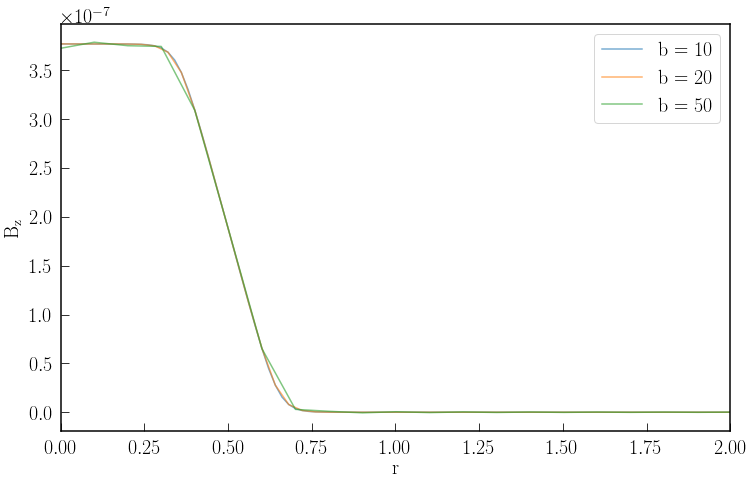

In [8]:
#Plotting Magnetic Field
for b_index in range(len(b_array)):

    r = np.linspace(epsilon, b_array[b_index], nr)
    pl.plot(r, expansion_B_z[:, b_index], label='$\mathrm{b = %d}$' %b_array[b_index], alpha=0.6)

#pl.axhline(y=0)
pl.xlabel('$\mathrm{r}$')
pl.ylabel('$\mathrm{B_z}$')
pl.legend(loc='best')
pl.xlim(0, 2)

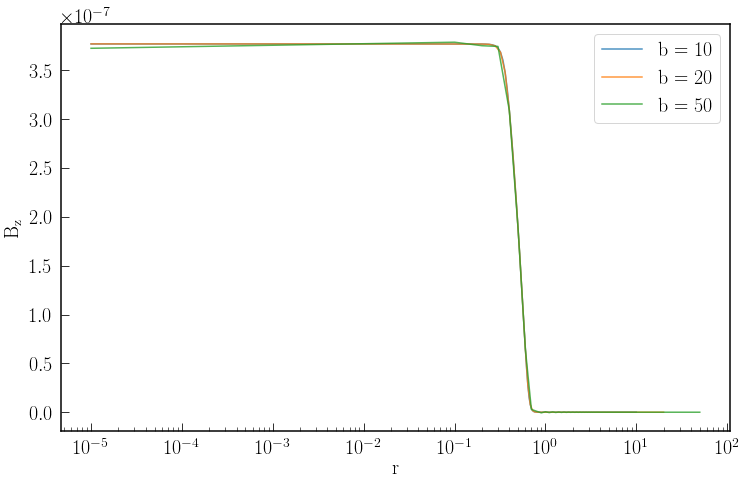

In [9]:
#Plotting Magnetic Field Semilog x

for b_index in range(len(b_array)):

    r = np.linspace(epsilon, b_array[b_index], nr)
    pl.semilogx(r, expansion_B_z[:, b_index], label='$\mathrm{b = %d}$' %b_array[b_index], alpha=0.8)

#pl.axhline(y=0, alpha=0.4)
pl.xlabel('$\mathrm{r}$')
pl.ylabel('$\mathrm{B_z}$')
pl.legend(loc='best')
#pl.ylim(-1e-8, 1e-8)


### Plotting the Vector Magnetic Field

In [10]:
nz = 500

r    = np.linspace(epsilon, b, nr)
z    = np.linspace(-2, 2, nz)
R, Z = np.meshgrid(r, z)

w = 3

expansion_curl_J_phi, c = fourier_bessel_expansion(curl_j_phi, r, epsilon, b, N, alpha)
expansion_B_z       , d = B_z_fourier_bessel_expansion(r, epsilon, b, N, alpha, c)

Br, Bz = np.zeros((nz, nr)), np.zeros((nz, nr))

for point in range(nr):
    Bz[:, point].fill(expansion_B_z[point])

/home/gitansh95/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/gitansh95/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(0, 3)

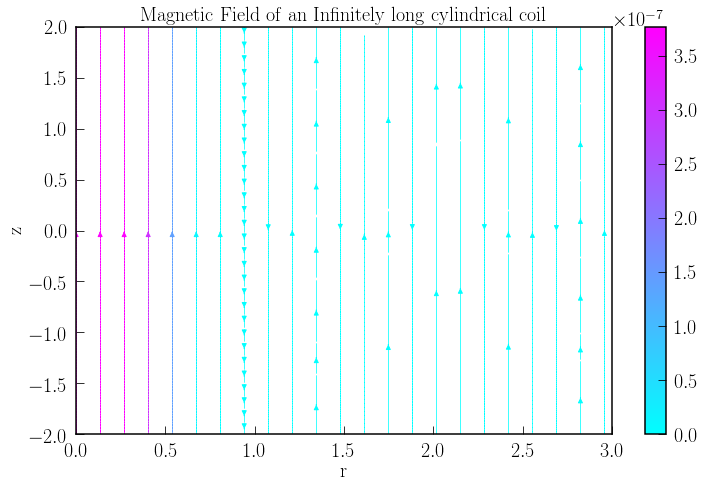

In [11]:
import matplotlib.gridspec as gridspec

B_value = np.sqrt(Br*Br + Bz*Bz)
speed = B_value

fig = plt.figure()
ax0 = fig.gca()
strm = ax0.streamplot(R, Z, Br, Bz, color=speed, linewidth=1, cmap='cool', density=5)
fig.colorbar(strm.lines)
ax0.set_title('$\mathrm{Magnetic\ Field\ of\ an\ Infinitely\ long\ cylindrical\ coil}$')
ax0.set_xlabel('$\mathrm{r}$')
ax0.set_ylabel('$\mathrm{z}$')
pl.xlim(0,3)